# Visualización

Proyecto PAPIME PE102723

**Referencias**
* [Feature Visualization by Optimization](https://distill.pub/2017/feature-visualization/), Olah et al.

Se utilizará una técnica de optimización de activación con respecto a los datos de entrada $X$ para identificar la imagen prototípica aprendida por una red convolucional, para cada concepto (clase ó etiqueta) entrenado.

In [1]:
#!pip install ipywidgets

In [2]:
from ipywidgets import interact_manual
import ipywidgets as widgets

## Datos de CIFAR-10

In [3]:
#!pip3 install torch torchvision torchaudio  # con cuda 12.04
#!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118  # cpu, sin cuda

In [4]:
import torch
import torchvision
import torchvision.transforms as transforms

In [5]:
# Torchvision devuelve imágenes en el rango [0, 1]
# Necesitamos tensores en [-1,1].
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [6]:
batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
label_names = trainset.classes
print(label_names)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [8]:
# Conjuntos de datos
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler

#Training
n_training_samples = 20000
train_sampler = SubsetRandomSampler(np.arange(n_training_samples, dtype=np.int64))

#Validation
n_val_samples = 5000
val_sampler = SubsetRandomSampler(np.arange(n_training_samples, n_training_samples + n_val_samples, dtype=np.int64))

#Test
n_test_samples = 5000
test_sampler = SubsetRandomSampler(np.arange(n_test_samples, dtype=np.int64))

## Red neuronal

### Arquitectura

<img src="./figuras/Tutorial.png"/>

In [9]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    
    #Our batch shape for input x is (3, 32, 32)
    
    def __init__(self):
        super(SimpleCNN, self).__init__()
        
        #Input channels = 3, output channels = 18
        self.conv1 = torch.nn.Conv2d(3, 18, kernel_size=3, stride=1, padding=1)
        self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        #4608 input features, 64 output features (see sizing flow below)
        self.fc1 = torch.nn.Linear(18 * 16 * 16, 64)
        
        #64 input features, 10 output features for our 10 defined classes
        self.fc2 = torch.nn.Linear(64, 10)
        
    def forward(self, x):
        
        #Computes the activation of the first convolution
        #Size changes from (3, 32, 32) to (18, 32, 32)
        x = F.relu(self.conv1(x))
        
        #Size changes from (18, 32, 32) to (18, 16, 16)
        x = self.pool(x)
        
        #Reshape data to input to the input layer of the neural net
        #Size changes from (18, 16, 16) to (1, 4608)
        #Recall that the -1 infers this dimension from the other given dimension
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        
        #Computes the activation of the first fully connected layer
        #Size changes from (1, 4608) to (1, 64)
        x = F.relu(self.fc1(x))
        
        #Computes the second fully connected layer (activation applied later)
        #Size changes from (1, 64) to (1, 10)
        x = self.fc2(x)
        return(x)

In [10]:
net = SimpleCNN()

In [11]:
# Cargamos los parámetros entrenados en el otro cuaderno

PATH = './data/cifar_net.pth'
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [12]:
import torch.optim as optim

In [13]:
# Muestra la imagen
import matplotlib.pyplot as plt

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

### Selección de la imagen inicial

#### Del conjunto de datos

Se puede introducir como punto de partida una de las imágenes del conjunto de datos, el proceso de optimización modificará esta imagen hacia un mínimo del valor de activación de la neurona correspondiente al concepto de interés.

In [14]:
# Tomamos una imagen del conjunto como valor inicial
dataiter = iter(testloader)
images, labels = next(dataiter)

In [15]:
# El lote tiene tamaño 4, tomamos una de las imágenes
ind = 3                  # Imagen en el lote como punto de partida
x = images[ind:ind+1]    # Para mantener las dimensiones
x.requires_grad = True   # Calcularemos el gradiente con respecto a x

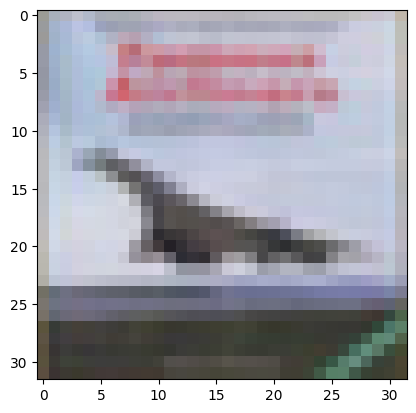

In [16]:
avión = x.detach()[0]
imshow(avión)

#### Ruido

El punto de partida o imagen inicial, podría ser también ruido aleatorio.

In [17]:
def ruido_centrado():
    """
    Crea una imagen de ruido aleatorio en el rango 
    requerido por la red, cuyo tensor sea una hoja,
    tal como requiere la función optimize.
    """
    ruido = torch.rand(1, 3, 32, 32) - 0.5       # Hay una resta, no es hoja.
    ruido = ruido.detach().requires_grad_(True)  # Lo convierte en hoja para poder sacar el gradiente
    return ruido

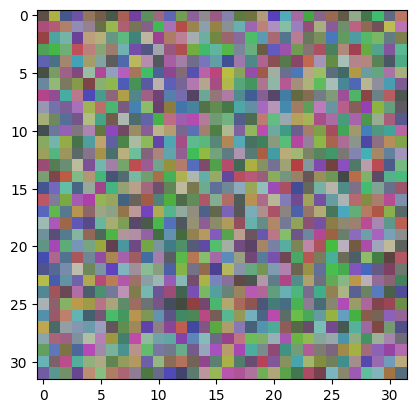

In [18]:
x = ruido_centrado()
imshow(x.detach()[0])

In [19]:
print(x.requires_grad)

True


### Cálculo del gradiente

A diferencia del proceso de entrenamiento, donde las variables a modificar son los pesos de la red, ahora las variables son las intensidades de los pixeles en cada canal RGB en la imagen de entrada.

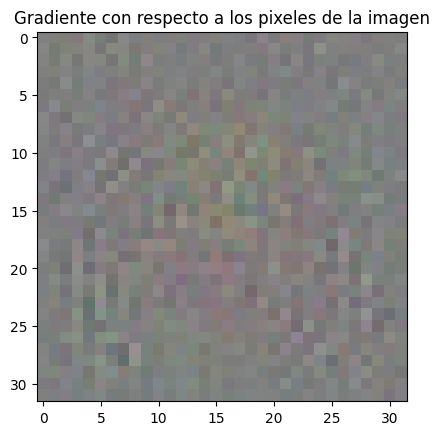

In [20]:
# Solicitamos el cálculo del gradiente con respecto a x

#https://stackoverflow.com/questions/69711410/could-not-initialize-nnpack
#torch.backends.nnpack.enabled = False

net.zero_grad()         # Buffer de gradientes de la red a ceros
x.grad = None           # Borra el buffer
output = -net(x)        # Queremos minimizar el negativo de la activación
output[0,0].backward()  # Calcula el gradiente para la activación de la neurona 0
imshow(x.grad.detach()[0])
_ = plt.title("Gradiente con respecto a los pixeles de la imagen")

### Optimización de una neurona de salida

In [21]:
# Indicamos algoritmo de optmización

#optimizer = optim.SGD((x,), lr=100, momentum=0.9)
optimizer = torch.optim.Adam((x,))

In [22]:
@interact_manual(
    one_hot_neuron = widgets.IntSlider(
        value=0,
        min=0,
        max=9,
        step=1,
    )
)
def optimiza_entrada(one_hot_neuron):
    hot_neuron_value = None
    for i in range(1000):
        optimizer.zero_grad()
        output = -net(x)   # To maximize
        hot_neuron_value = output[0,one_hot_neuron]
        hot_neuron_value.backward()
        optimizer.step()
    print(label_names[one_hot_neuron])
    print(-hot_neuron_value)
    #print(x.grad)
    imshow(torch.cat((x[0].detach(), x.grad.detach()[0]), 2))

interactive(children=(IntSlider(value=0, description='one_hot_neuron', max=9), Button(description='Run Interac…

In [23]:
# Veamos los valores de activación con la imagen optimizada
salidas = net(x).detach()[0]
for lb, val in zip(label_names, salidas):
    print(val, ":\t", lb)

tensor(56.5669) :	 airplane
tensor(-33.4737) :	 automobile
tensor(34.3262) :	 bird
tensor(-35.4539) :	 cat
tensor(2.9151) :	 deer
tensor(-35.3762) :	 dog
tensor(-53.6640) :	 frog
tensor(-29.1492) :	 horse
tensor(-23.8723) :	 ship
tensor(-54.1243) :	 truck


### Optimización con transformaciones

Para obtener imágenes con mayor significado, Olah et al. proponen realizar transformaciones a las imágenes obtenidas en cada paso del proceso de optimización.

In [24]:
blurrer = torchvision.transforms.GaussianBlur(3,0.27)
# jitter = torchvision.transforms.ColorJitter(hue=0.3, saturation=0.3, contrast=0.3)
original_x = x

In [25]:
@interact_manual(
    one_hot_neuron = widgets.IntSlider(
        value=0,
        min=0,
        max=9,
        step=1,
    )
)
def optimiza_entrada(one_hot_neuron):
    global original_x
    x = original_x.clone().detach().requires_grad_(True)
    print(x.requires_grad)
    hot_neuron_value = None
    for i in range(4000):
        x = blurrer(x).detach().requires_grad_(True)
        optimizer = torch.optim.Adam((x,))
        optimizer.zero_grad()
        #tr_x = jitter(x)
        #output = -net(tr_x)   # To maximize
        output = -net(x)   # To maximize
        hot_neuron_value = output[0,one_hot_neuron]
        hot_neuron_value.backward()
        #x = jitter(x)
        optimizer.step()
    print(label_names[one_hot_neuron])
    print(-hot_neuron_value)
    print(x.requires_grad)
    #print(x.grad)
    original_x = x
    
    imshow(torch.cat((x[0].detach(), x.grad.detach()[0]), 2))

interactive(children=(IntSlider(value=0, description='one_hot_neuron', max=9), Button(description='Run Interac…

In [26]:
# Veamos los valores de activación con la imagen optimizada
salidas = net(original_x).detach()[0]
for lb, val in zip(label_names, salidas):
    print(val, ":\t", lb)

tensor(35.8621) :	 airplane
tensor(-14.7785) :	 automobile
tensor(14.8385) :	 bird
tensor(-28.3529) :	 cat
tensor(0.4824) :	 deer
tensor(-23.8862) :	 dog
tensor(-52.3156) :	 frog
tensor(-7.8622) :	 horse
tensor(-19.8694) :	 ship
tensor(-26.2127) :	 truck


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


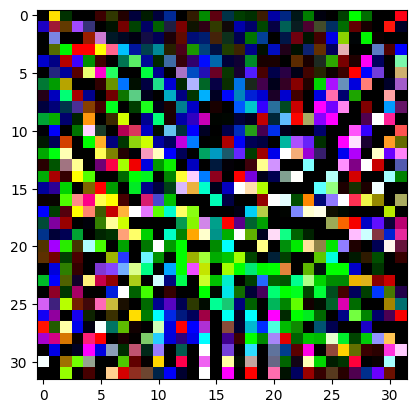

In [27]:
plt.imshow(np.transpose(x.detach().numpy()[0], (1, 2, 0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


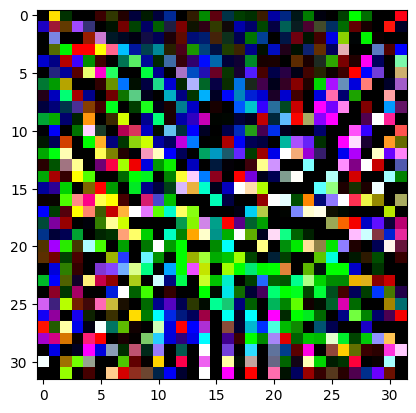

In [28]:
jx = blurrer(x)
plt.imshow(np.transpose(jx.detach().numpy()[0], (1, 2, 0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


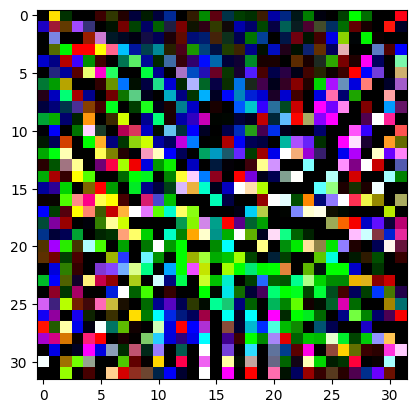

In [29]:
plt.imshow(np.transpose(x.detach().numpy()[0], (1, 2, 0)))

In [22]:
# TODO: Intenta ahora devolver los valores de los pixeles al rango válido [0-255] entre iteraciones para obtener imágenes válidas.